**Прогнозирование температуры звезды.**

C помощью нейросети определять температуру на поверхности обнаруженных звёзд.

## Загрузка данных

**Ревьюеру**

Благодарю за то что проверил(а) мой проект. Честно сказать он пока "сыроват". Видимо я что-то недопонял в обучении нейросети, потому что, что бы я не делал я получаю примерно одни и те же предсказания. Целевой признак имеет большой разброс по значениям, а полученые мной предсказания, ложатся в относительно небольшой диапозон. Понимаю что надо будет много чего доработать, буду благодарен за советы))

**Задача**

Придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

In [1]:
!pip install -q pandas_profiling
!pip install -q torchmetrics

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import torch
import torch.nn as nn
from itertools import chain
from numpy import array
from pandas.core.common import flatten
import itertools
from torchmetrics import MeanSquaredError
from sklearn.metrics import mean_squared_error

/tmp/ipykernel_48/1197873216.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
df = pd.read_csv('/datasets/6_class.csv')

In [4]:
df.head(5)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


**Вывод**

Перед нами структурированная таблица, в которой 7 столбцов и 240 строк:

- Относительная светимость Luminosity(L/Lo) — светимость звезды относительно Солнца.
- Относительный радиус Radius(R/Ro) — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Absolute magnitude(Mv) — физическая величина, характеризующая блеск звезды.
- Звёздный цвет Star color (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды Star type.
- Абсолютная температура Temperature (K) — температура на поверхности звезды в Кельвинах.
- Unnamed: 0 Просто нумерация, его удалим.

Целевым признаком является Temperature (K). 


## Предобработка и анализ данных

Сначало удалим столбец Unnamed: 0 это просто нумерация и этот столбец нам в дальнейшем не понадобится.

In [6]:
df = df.drop('Unnamed: 0', axis=1)

Теперь проверим наличие пропусков и дубликатов.

In [7]:
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [8]:
df.duplicated().sum()

0

Попробуем разобратся с не явными дубликатами в столбце "Star color".

In [9]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
white                   3
Blue white              3
Orange                  2
yellowish               2
Whitish                 2
White-Yellow            1
Orange-Red              1
Pale yellow orange      1
Blue                    1
Yellowish               1
Blue-White              1
Blue white              1
Name: Star color, dtype: int64

Мы видим разные стили написания одних и тех же значений, а так же использование синонимов. Приведём всё к единому стилю и сгруппируем синонимы.

In [10]:
df['Star color'] = df['Star color'].replace('white', 'White')
df['Star color'] = df['Star color'].replace('Blue White', 'Blue-white')
df['Star color'] = df['Star color'].replace('Blue white ', 'Blue-white')
df['Star color'] = df['Star color'].replace('Blue white', 'Blue-white')
df['Star color'] = df['Star color'].replace('Blue-White', 'Blue-white')
df['Star color'] = df['Star color'].replace('Blue ', 'Blue')
df['Star color'] = df['Star color'].replace('yellow-white', 'Yellow-white')
df['Star color'] = df['Star color'].replace('Yellowish White', 'Yellow-white')
df['Star color'] = df['Star color'].replace('White-Yellow', 'Yellow-white')
df['Star color'] = df['Star color'].replace('yellowish', 'Yellowish')
df['Star color'] = df['Star color'].replace('Whitish', 'White')
df['Star color'] = df['Star color'].replace('Orange-Red', 'Red')
df['Star color'] = df['Star color'].replace('Pale yellow orange', 'Orange')

In [11]:
df['Star color'].value_counts()

Red             113
Blue             56
Blue-white       41
White            12
Yellow-white     12
Orange            3
Yellowish         3
Name: Star color, dtype: int64

In [12]:
df['Star color'].unique()

array(['Red', 'Blue-white', 'White', 'Yellow-white', 'Orange', 'Blue',
       'Yellowish'], dtype=object)

В результате вышеизложенных преобразований у нас осталось шесть категорий.

Теперь преобразуем столбец "Star type" в тип object чтобы божно было применить к нему метод прямого кодирования.

In [13]:
df['Star type'] = df['Star type'].astype(object)

Теперь в качестве графического анализа сделаем отчет profile_report() из pandas_profiling, он будет с учетом уже проделаных изменений.

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

Категорильные данные:
- Star color (7 уникальных значений)
- Star type (6 уникальных значений)

Количественные данные:
- Luminosity(L/Lo) (208 уникальных значений)
- Radius(R/Ro) (216 уникальных значений)
- Absolute magnitude(Mv) (228 уникальных значений)

Целевой признак:
- Temperature (K)

Дубликатов и пропусков не обнаружено.


## Построение базовой нейронной сети

### Подготовка данных

#### Разделение датафрейма на тренировочную, валидационную и тестовую выборки

Разобъём данные на признаки и целевой признак, для этого сначала аазделим датафрейм на числовые и категорильные признаки.

Как мы увидили из отчета profile_report() параметр 'Radius(R/Ro) не коррелируется с целевым признаком, по этому удалим его.  

In [15]:
df = df.drop('Radius(R/Ro)', axis=1)

In [16]:
numeric = ['Luminosity(L/Lo)', 'Absolute magnitude(Mv)']
df_numeric = df[numeric]
category = ['Star type', 'Star color']
df_category = df[category]
target = df['Temperature (K)'] 

В начале применим метод прямого кодирования, категорильных признаков.

In [17]:
features_category = pd.get_dummies(df_category, drop_first=True)

Теперь проведём масштабирование численных признаков

In [18]:
scaler = StandardScaler()
scaler.fit(df_numeric)

features_numeric = scaler.transform(df_numeric)
features_numeric = pd.DataFrame(features_numeric, columns=df_numeric.columns)

In [19]:
features = pd.concat([features_category, features_numeric], axis=1)
features.shape

(240, 13)

Теперь разобьём данные на тренировочные, валидационные и тестовые.

In [20]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345)
# Отделяем обучающую выборку

In [21]:
print('Размер тренировочной выборки', features_train.shape)
print('Размер валидационной выборки', features_valid.shape)

Размер тренировочной выборки (144, 13)
Размер валидационной выборки (96, 13)


### Построение нейросети

Создание тензоров.

In [22]:
X_train = torch.FloatTensor(features_train.values)
X_valid = torch.FloatTensor(features_valid.values)
y_train = torch.FloatTensor(target_train.values)
y_valid = torch.FloatTensor(target_valid.values)

Создание класса и функции для полчения предсказаний.

In [23]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,  n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        
        x = self.fc3(x)

        
        return x 

Создадим функцию для обучения нейросети.

In [24]:
list_result = []

In [25]:
def network_training(net, num_epochs, X_train, y_train, X_valid, y_valid):
    global best_model
    best_model = 1
    best_RMSE = 25000
    net = net
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-2)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds_train = net.forward(X_train).flatten()
        RMSE_loss = torch.sqrt(loss(preds_train, y_train))
        RMSE_loss.backward()
        
        optimizer.step()
        
        RMSE_train = np.sqrt(mean_squared_error(y_train.detach().numpy(), preds_train.detach().numpy()))
        net.eval()        
        preds_valid = net.forward(X_valid)
        RMSE_valid = np.sqrt(mean_squared_error(y_valid.detach().numpy(), preds_valid.detach().numpy()))
        
        if epoch % 120 == 0 or epoch == num_epochs - 1:
            list_result.append([epoch, RMSE_train, RMSE_valid])
        if best_RMSE > RMSE_valid:
            best_RMSE = RMSE_valid
            best_model = net
        
    return list_result, best_model
            

In [26]:
n0 = features_train.shape[1]
n1 = 8
n2 = 3
nout = 1
num_epochs = 8000

Посмотрим RMSE на тренировочной и на валидационной выборке

In [27]:
net = Net(n0, n1, n2, nout)

In [28]:
network_training(net, num_epochs, X_train, y_train, X_valid, y_valid)
result_df = pd.DataFrame(list_result).loc[::,:2]
result_df = result_df.rename(columns={0:'Эпоха',1:'RMSE_train',2:'RMSE_valid'})
result_df.head(5)

,Эпоха,RMSE_train,RMSE_valid
0,0,13686.070312,14891.443359
1,120,13655.249023,14860.652344
2,240,13574.821289,14780.885742
3,360,13446.705078,14654.027344
4,480,13273.364258,14482.483398


In [29]:
result_df.sort_values('RMSE_valid').head()

,Эпоха,RMSE_train,RMSE_valid
63,7560,2712.362793,4827.282227
64,7680,2706.354492,4830.379395
62,7440,2720.107178,4830.951660
61,7320,2731.074951,4834.758301
65,7800,2701.787109,4835.311523


Теперь построим график изменения RMSE на тренировочной и валидационной выборках.

In [30]:
def graph_RMSE(x,y,y2):
   
    plt.plot(x, y, 'b', label='RMSE_train', linewidth=2)   
    plt.plot(x, y2, 'r', label='RMSE_valid', linewidth=2)   
    plt.title('Диаграмма RMSE')   
    plt.ylabel('Значение RMSE')   
    plt.xlabel('Количество эпох обучения')
    plt.legend()
    fig = plt.figure(figsize=(15, 8))
    plt.show()
    

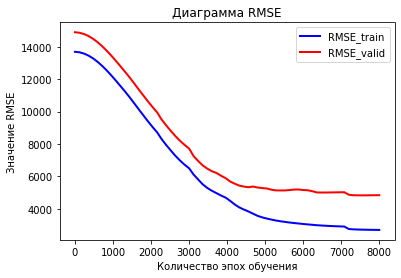

<Figure size 1080x576 with 0 Axes>

In [31]:
graph_RMSE(result_df['Эпоха'], result_df['RMSE_train'], result_df['RMSE_valid'])

Как мы видим из графика сеть переучилась.

Построим диаграмму факт - прогноз

In [32]:
new_valid_preds = best_model.forward(X_valid)

Сделаем функцию для построения диаграммы факт прогноз.

In [33]:
def graph_predict(x,y):
        
    preds = np.asarray(list(itertools.chain.from_iterable(x.data.numpy())))
    
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = np.arange(len(y))
    
    plt.bar(x_range, y.data.numpy(), color='#aae6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='Факт')
    plt.bar(x_range, preds, color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Прогноз')
    
    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':15}, ncol = 2)
    plt.ylabel("Температура звезды", fontsize=15, weight='bold')
    plt.xlabel("Номер звезды в таблице данных", fontsize=15, weight='bold')
    
    plt.rcParams['figure.figsize'] = [15, 8]
    
    plt.rcParams.update({'font.size': 15})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

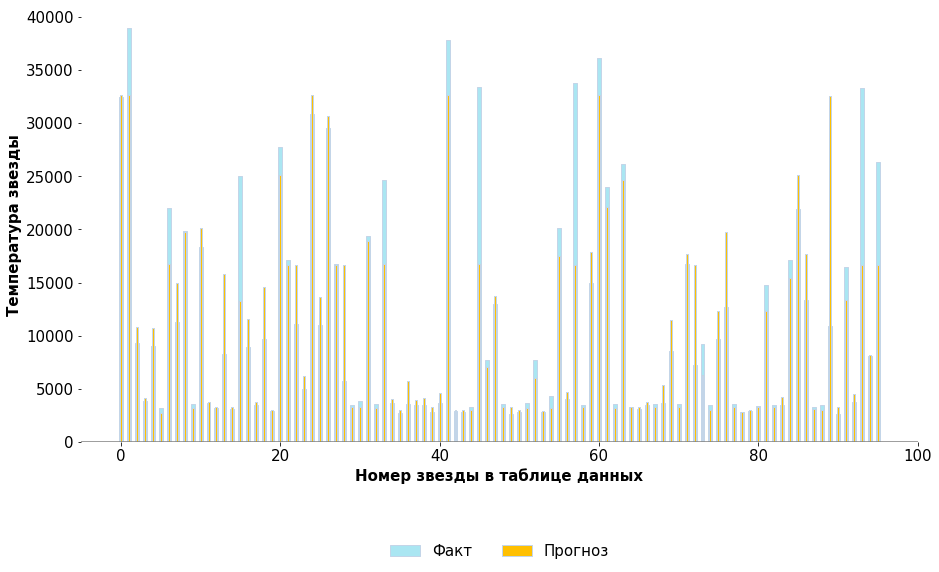

In [52]:
graph_predict(new_valid_preds  , y_valid)

**Вывод** Мы построили базовую нейросеть:

Net(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)
Обучали на 8000 эпохах. Сеть переучилась, но лучшее значение RMSE не валидационной выборке 4576, мы получили при 5040
эпох.

Это не соответствует нашим условиям, попробуем её улучшить.

## Улучшение нейронной сети

Теперь попробуем улучшить нейронную сеть.

Добавим регуляризацию методом "Dropout" и переберём параметр p и добавим батч-нормализацию.

In [35]:
class Net_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,  n_out_neurons, p1):
        super(Net_1, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=p1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)

        
        return x

Создадим новую функцию для обучения сети с перебором параметров.

In [36]:
def network_training_1(net, num_epochs:int, X_train, y_train, X_valid, y_valid, p1):
    

    best_RMSE = 25000
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-2)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        RMSE_loss = torch.sqrt(loss(preds, y_train))
        RMSE_loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            preds = net.forward(X_valid)
            preds = list(array(preds.detach().numpy()).flat) 
            RMSE = np.sqrt(mean_squared_error(preds, y_valid))
            if best_RMSE > RMSE:
                best_RMSE = RMSE
                best_epoch = epoch
                best_model = net
            optimizer.step()
    return (best_RMSE.tolist(), p1, best_model)

In [37]:
result_list_1 = []
result_list_valid_1 = []
p_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n0 = features_train.shape[1]
n1 = 8
n2 = 3
nout = 1
num_epochs = 7000

In [38]:
for p1 in p_1: 
    net_1 = Net_1(n0, n1,n2,nout, p1,)
    a = network_training_1(net_1, num_epochs, X_train, y_train, X_valid, y_valid, p1)
    result_list_1.append(a)
    print(p1)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [39]:
result_df = pd.DataFrame(result_list_1).loc[::,:2]
result_df=result_df.rename(columns={0:'RMSE_valid',1:'p1',2:'best_model'})
result_df.sort_values('RMSE_valid').head()


,RMSE_valid,p1,best_model
0,4291.856934,0.1,"Net_1(\n (fc1): Linear(in_features=13, out_fe..."
4,4327.812500,0.5,"Net_1(\n (fc1): Linear(in_features=13, out_fe..."
5,4684.803711,0.6,"Net_1(\n (fc1): Linear(in_features=13, out_fe..."
3,4748.518066,0.4,"Net_1(\n (fc1): Linear(in_features=13, out_fe..."
8,4753.863281,0.9,"Net_1(\n (fc1): Linear(in_features=13, out_fe..."


Лучший результат мы получили при значении p1 = 0.2 при этом по умолчанию мы использовали значение p2 = 0.2. Теперь попробуем перебрать значения p2.

In [40]:
class Net_2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,  n_out_neurons, p1):
        super(Net_2, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.7)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=p1)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)

        
        return x

In [41]:
result_list_2 = []
result_list_valid_2 = []
p_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n0 = features_train.shape[1]
n1 = 8
n2 = 3
nout = 1
num_epochs = 7000

In [42]:
for p1 in p_1: 
    net_2 = Net_2(n0, n1,n2,nout, p1)
    b = network_training_1(net_2, num_epochs, X_train, y_train, X_valid, y_valid, p1)
    result_list_2.append(b)
    print(p1)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [43]:
result_df_1 = pd.DataFrame(result_list_2).loc[::,:2]
result_df_1 = result_df_1.rename(columns={0:'RMSE_valid',1:'p1',2:'best_model'})
result_df_1.sort_values('RMSE_valid').head()


,RMSE_valid,p1,best_model
5,4258.517578,0.6,"Net_2(\n (fc1): Linear(in_features=13, out_fe..."
4,4510.439941,0.5,"Net_2(\n (fc1): Linear(in_features=13, out_fe..."
3,4665.366699,0.4,"Net_2(\n (fc1): Linear(in_features=13, out_fe..."
1,4678.455078,0.2,"Net_2(\n (fc1): Linear(in_features=13, out_fe..."
6,4735.178223,0.7,"Net_2(\n (fc1): Linear(in_features=13, out_fe..."


При значении 0.6 мы получили лучшие результаты.

Обучение с применением батчей не дало нам улучшения результата. Вернёмся к ранее выбранной модели.

In [49]:
best_m = result_df_1.loc[1,'best_model']
best_m

Net_2(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (dp1): Dropout(p=0.7, inplace=False)
  (act1): Tanh()
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

In [50]:
final_valid_preds = best_m.forward(X_valid)

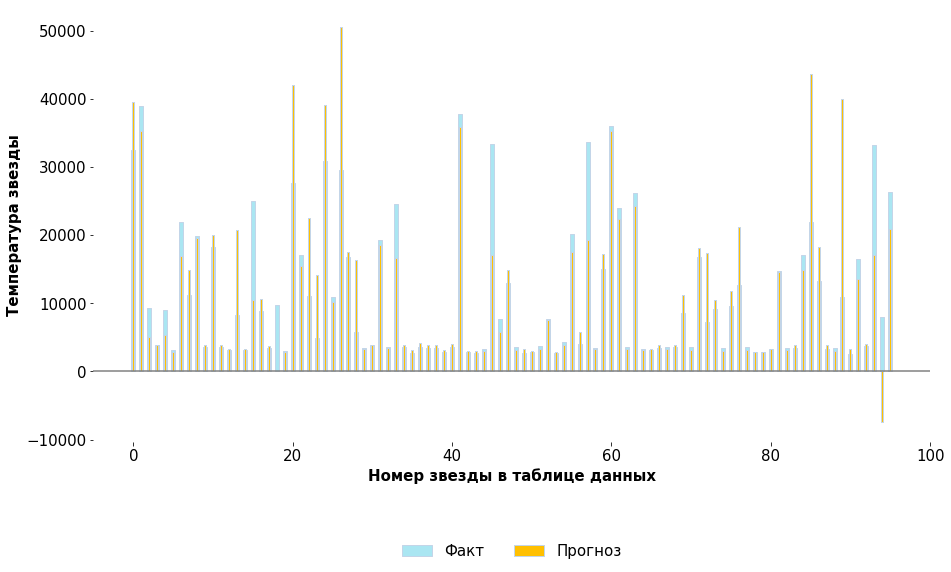

In [51]:
graph_predict(final_valid_preds  , y_valid)

## Выводы

###### Базовая модель

Базовая модель была построена с параметрами:

n_in_neurons = 13
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 3
n_out_neurons = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2)
loss = nn.MSELoss()
Функции активации Tanh() и RelU()

Данная модель оказалась неэффективна. Метрика RMSE получилась > 4537 тыс, что нас не удовлетворяло, так как по условию нужно было получить метрику не выше 4500.

Улучшенная модель

улучшенная модель строилась с использованием , батч-нормализации, и метода droupout
использовался перебор параметров p:

Количества слоёв и функции активации использовальсь те же, что и в базовой модели.
Dropout-1 p=0.2
Dropout-2 p=0.6

Данную модель можно считать эффективной. Метрика RMSE получилась 4258.51

Сравнивая две диаграммы факт-прогноз, можно явно увидеть улучшение качества пердсказаний. 